In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [2]:
file_path = '../../data/data.csv'
df = pd.read_csv(file_path, parse_dates=['Date'])
#df = df.dropna()

df.head()

,Date,Inflation,CPI,Treasury_Yield,Open,High,Low,Close,SP500_Adj_Close,Volume,...,volatility,volatility_forcast,returns,EWMA_VM,GARCH_VM,EGARCH_VM,RogersSatchell_VM,garman_klass,parkinson,yang_zhang
0,2003-01-03,1.62,182.6,4.05,909.03,911.25,903.07,908.59,908.59,1130800000,...,0.9058,2.5512,-0.0005,0.0116,0.0002,0.0182,0.0069,0.0064,0.0054,0.0090
1,2003-01-06,1.63,182.6,4.09,908.59,931.77,908.59,929.01,929.01,1435900000,...,2.5512,1.1827,0.0222,0.0112,0.0003,0.0267,0.0086,0.0112,0.0151,0.0252
2,2003-01-07,1.62,182.6,4.04,929.01,930.81,919.93,922.93,922.93,1545200000,...,1.1827,1.6085,-0.0066,0.0122,0.0003,0.0376,0.0070,0.0072,0.0071,0.0118
3,2003-01-08,1.71,182.6,4.00,922.93,922.93,908.32,909.93,909.93,1467600000,...,1.6085,2.0199,-0.0142,0.0119,0.0004,0.0512,0.0053,0.0070,0.0096,0.0160
4,2003-01-09,1.78,182.6,4.19,909.93,928.31,909.93,927.57,927.57,1560300000,...,2.0199,1.6597,0.0192,0.0121,0.0004,0.0675,0.0040,0.0076,0.0120,0.0200


In [3]:
target = 'volatility_forcast'
date='Date'

df=df.drop(columns=[date])
X = df.drop(columns=[target])
y = df[target]


In [4]:
if len(X.shape) == 2:
    X = np.expand_dims(X, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [5]:
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(sequence_len, d_model)

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model
        )
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / tf.pow(10000, (2 * (i//2)) / tf.cast(d_model, tf.float32))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Transformer encoder block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.0):
    attn_output = layers.MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=dropout
    )(inputs, inputs)
    x = layers.Add()([inputs, attn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    ffn_output = layers.Dense(ff_dim, activation="relu")(x)
    ffn_output = layers.Dropout(dropout)(ffn_output)
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    x = layers.Add()([x, ffn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x


In [6]:
input_shape = X_train.shape[1:] 

# Build the model
inputs = layers.Input(shape=input_shape)
# Add positional encoding
x = PositionalEncoding(sequence_len=input_shape[0], d_model=input_shape[1])(inputs)
# Stack multiple transformer blocks
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1)(x)


In [7]:
model = models.Model(inputs, outputs)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss="mean_squared_error")

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 22)]              0         []                            
                                                                                                  
 positional_encoding (Posit  (None, 1, 22)                0         ['input_1[0][0]']             
 ionalEncoding)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 1, 22)                23318     ['positional_encoding[0][0]', 
 iHeadAttention)                                                     'positional_encoding[0][0]'] 
                                                                                              

In [8]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/100

135/135 [==============================] - 5s 10ms/step - loss: 1.0216 - val_loss: 1.0800 - lr: 0.0010
Epoch 2/100
135/135 [==============================] - 1s 7ms/step - loss: 0.9882 - val_loss: 1.0808 - lr: 0.0010
Epoch 3/100
135/135 [==============================] - 1s 7ms/step - loss: 0.9704 - val_loss: 1.0789 - lr: 0.0010
Epoch 4/100
135/135 [==============================] - 1s 7ms/step - loss: 0.9687 - val_loss: 1.0816 - lr: 0.0010
Epoch 5/100
135/135 [==============================] - 1s 7ms/step - loss: 0.9657 - val_loss: 1.1037 - lr: 0.0010
Epoch 6/100
132/135 [============================>.] - ETA: 0s - loss: 0.9605
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
135/135 [==============================] - 1s 7ms/step - loss: 0.9692 - val_loss: 1.0793 - lr: 0.0010
Epoch 7/100
135/135 [==============================] - 1s 7ms/step - loss: 0.9585 - val_loss: 1.0860 - lr: 5.0000e-04
Epoch 8/100
135/135 [==============================] -

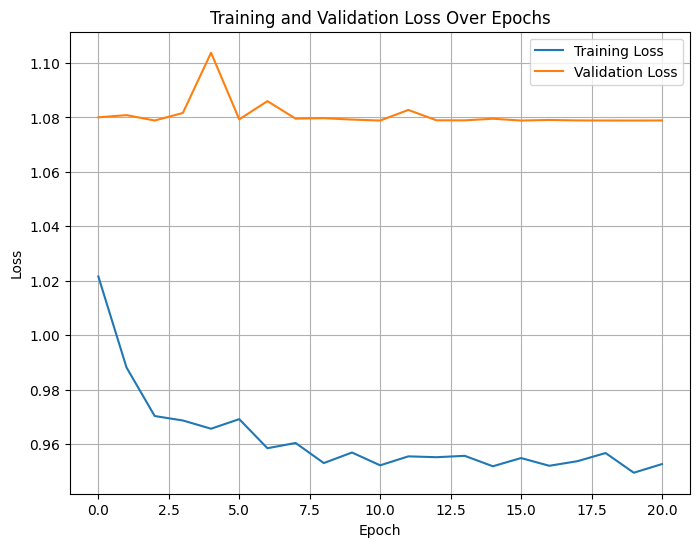

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


34/34 [==============================] - 1s 4ms/step


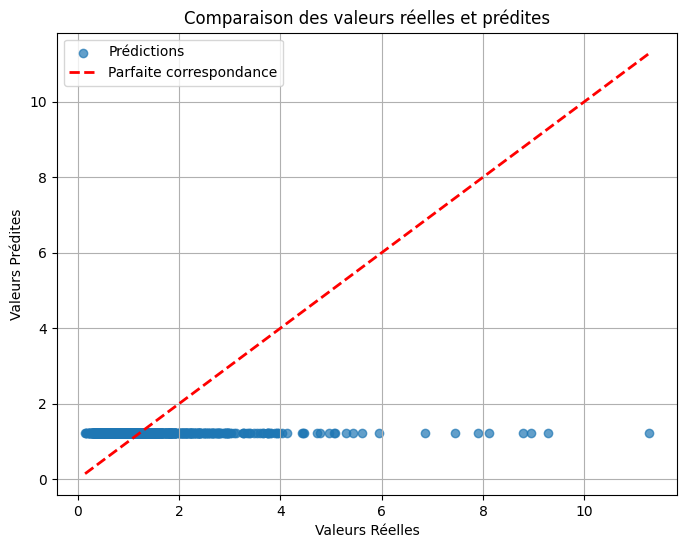

In [10]:
y_pred = model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label="Prédictions")
min_val = min(np.min(y_test), np.min(y_pred))
max_val = max(np.max(y_test), np.max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Parfaite correspondance")
plt.xlabel("Valeurs Réelles")
plt.ylabel("Valeurs Prédites")
plt.title("Comparaison des valeurs réelles et prédites")
plt.legend()
plt.grid(True)
plt.show()


### Need more data for a Transformer (see /data/stocks/*.csv)